# Upscale Images

Imports

In [1]:
import torch
from src.esrgan import RRDBNet
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision.transforms import functional as F
from torch.amp import autocast
import math

Function to Load Model saved in ./models

In [2]:
def load_model(model_path, device):
    print(f"Loading model from: {model_path}")
    generator = RRDBNet().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    print("Model loaded successfully!")
    return generator

Function to Upscale Images

In [3]:
def upscale_image(generator, lr_image_path, output_path, device, tile_size=128, tile_overlap=16):
    print(f"Loading image: {lr_image_path}")
    lr = Image.open(lr_image_path).convert("RGB")
    w, h = lr.size
    print(f"Original size: {w}x{h}")

    lr_t = F.to_tensor(lr).unsqueeze(0).to(device)
    generator.eval()

    stride = tile_size - tile_overlap

    pad_h = (math.ceil(h / stride) * stride + tile_overlap) - h
    pad_w = (math.ceil(w / stride) * stride + tile_overlap) - w
    lr_t = torch.nn.functional.pad(lr_t, (0, pad_w, 0, pad_h), mode="reflect")

    _, _, H, W = lr_t.shape
    out = torch.zeros((1, 3, H * 4, W * 4), device=device)

    crop = (tile_overlap // 2) * 4

    print("Upscaling")
    with torch.no_grad():
        for y in range(0, H - tile_overlap, stride):
            for x in range(0, W - tile_overlap, stride):
                tile = lr_t[:, :, y:y+tile_size, x:x+tile_size]

                with autocast(device_type="cuda", enabled=(device == "cuda")):
                    tile_out = generator(tile)

                oy, ox = y * 4, x * 4

                top = crop if y > 0 else 0
                left = crop if x > 0 else 0
                bottom = crop if y + tile_size < H else 0
                right = crop if x + tile_size < W else 0

                tile_out = tile_out[:, :,
                    top : tile_out.shape[2] - bottom,
                    left: tile_out.shape[3] - right
                ]

                out[:, :,
                    oy + top : oy + top + tile_out.shape[2],
                    ox + left: ox + left + tile_out.shape[3]
                ] = tile_out

    out = out[:, :, :h*4, :w*4]
    out = torch.clamp(out, 0, 1)

    sr_img = F.to_pil_image(out.squeeze(0).cpu())
    sr_img.save(output_path)

    print(f"Upscaled size: {sr_img.size[0]}x{sr_img.size[1]}")
    print(f"Saved to: {output_path}")


Function to Compare Original and Upscaled Images

In [4]:
def comparison(lr, sr):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0, 0].imshow(lr)
    axes[0, 0].set_title("Original Image (Full)")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(sr)
    axes[0, 1].set_title("Upscaled Image (Full)")
    axes[0, 1].axis("off")

    zoom_size = 200
    lr_width, lr_height = lr.size
    max_x = max(0, lr_width - zoom_size)
    max_y = max(0, lr_height - zoom_size)

    if max_x > 0 and max_y > 0:
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        zoom_box_lr = (x, y, x + zoom_size, y + zoom_size)
        zoom_box_sr = (x * 4, y * 4, (x + zoom_size) * 4, (y + zoom_size) * 4)
        
        lr_zoom = lr.crop(zoom_box_lr)
        sr_zoom = sr.crop(zoom_box_sr)
        
        axes[1, 0].imshow(lr_zoom)
        axes[1, 0].set_title(f"Original - Zoomed")
        axes[1, 0].axis("off")
        
        axes[1, 1].imshow(sr_zoom)
        axes[1, 1].set_title(f"Upscaled - Zoomed")
        axes[1, 1].axis("off")
    else:
        axes[1, 0].text(0.5, 0.5, "Image too small for zoom", ha='center', va='center')
        axes[1, 1].text(0.5, 0.5, "Image too small for zoom", ha='center', va='center')

    plt.tight_layout()
    plt.show()

### Important Parameters
- device: GPU is highly preferred, CPU would work but would be painfully slow.
- model_path: ./models has ESRGAN.pth and ESRGAN_PSNR.pth. Only use the ESRGAN.pth, the other one is Phase 1 (PSNR) Trained only.
- input_image: You can place the image anywhere, preferably in ./images.
- output_path: You can place it anywhere, preferably in ./images.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
model_path = "models/ESRGAN.pth"
input_image = "images/example_1.jpg"
output_path = "images/example_output_5.png"

Using device: cuda



4x Upscale your Image

Loading model from: models/ESRGAN.pth
Model loaded successfully!
Loading image: images/example_1.jpg
Original size: 427x640
Upscaling
Upscaled size: 1708x2560
Saved to: images/example_output_5.png


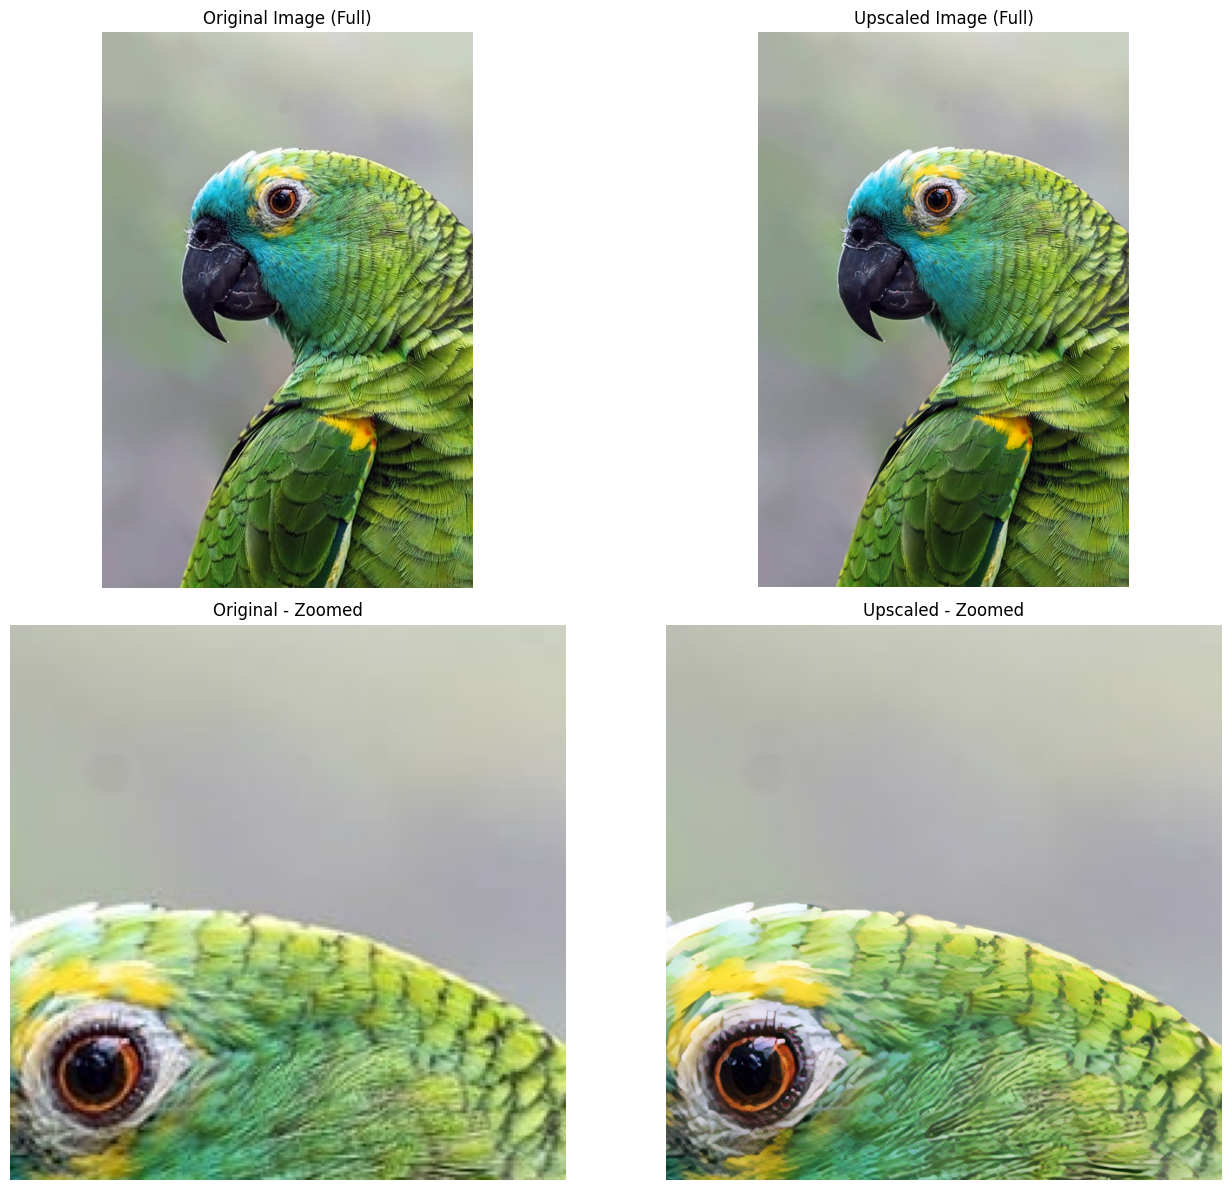

In [6]:
generator = load_model(model_path, device)
upscale_image(generator, input_image, output_path, device)

lr = Image.open(input_image).convert("RGB")
sr = Image.open(output_path).convert("RGB")

comparison(lr, sr)